In [ ]:
!nvidia-smi

Tue Oct  6 05:15:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports and Utility functions

## <font color='orange'>Imports</font>

In [ ]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py

#%tensorflow_version 2.x
#%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Reshape
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.activations import relu

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers, activations
from tensorflow.keras.utils import to_categorical, Sequence

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as ppi_irv2

In [ ]:
np.random.seed(16)
tf.random.set_seed(16)

## <font color='orange'>Analysing and Cleaning Data</font>

## Files

In [ ]:
mrnet_path = './Datasets/MRNet/MRNet-v1.0'
contents = os.listdir(mrnet_path)
print(contents)
print('\nLabel Files...')
label_files = [x for x in contents if x.endswith('.csv')]
print(label_files)

['valid', 'valid-abnormal.csv', 'train-meniscus.csv', 'train', 'train-abnormal.csv', 'train-acl.csv', '.DS_Store', 'valid-acl.csv', 'valid-meniscus.csv']

Label Files...
['valid-abnormal.csv', 'train-meniscus.csv', 'train-abnormal.csv', 'train-acl.csv', 'valid-acl.csv', 'valid-meniscus.csv']


In [ ]:
#Needs to be done once
classes = ['axial','sagittal','coronal']
fileToBeDeleted = '.DS_Store'
for c in classes:
    os.remove(mrnet_path+'/train/'+c+'/'+fileToBeDeleted)
print(fileToBeDeleted in os.listdir(mrnet_path+'/train/axial'))
print(fileToBeDeleted in os.listdir(mrnet_path+'/train/sagittal'))
print(fileToBeDeleted in os.listdir(mrnet_path+'/train/coronal'))

False
False
False


### Real Labels

In [ ]:
#For Colab /root/MRNet/MRNet-v1.0/
trabn = pd.read_csv(mrnet_path+'/train-abnormal.csv',header=None)
#trabn.head()
tracl = pd.read_csv(mrnet_path+'/train-acl.csv',header=None)
#tracl.head()
trmen = pd.read_csv(mrnet_path+'/train-meniscus.csv',header=None)
#trmen.head()

In [ ]:
trabn.columns = ['patient_id','label']
tracl.columns = ['patient_id','label']
trmen.columns = ['patient_id','label']

In [ ]:
tr_multilabel = trabn.merge(tracl,on='patient_id').merge(trmen,on='patient_id')
tr_multilabel.columns = ['patient_id','abn','acl','men']
tr_multilabel.head()

,patient_id,abn,acl,men
0,0,1,0,0
1,1,1,1,1
2,2,1,0,0
3,3,1,0,1
4,4,1,0,0


In [ ]:
tr_multilabel.to_csv('tr_multilabl.csv',header=True)

In [ ]:
#For Colab /root/MRNet/MRNet-v1.0/
valabn = pd.read_csv(mrnet_path+'/valid-abnormal.csv',header=None)
valacl = pd.read_csv(mrnet_path+'/valid-acl.csv',header=None)
valmen = pd.read_csv(mrnet_path+'/valid-meniscus.csv',header=None)

In [ ]:
valabn.columns = ['patient_id','label']
valacl.columns = ['patient_id','label']
valmen.columns = ['patient_id','label']

In [ ]:
val_multilabel = valabn.merge(valacl,on='patient_id').merge(valmen,on='patient_id')
val_multilabel.columns = ['patient_id','abn','acl','men']
val_multilabel.head(120)

,patient_id,abn,acl,men
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0
...,...,...,...,...
115,1245,1,1,1
116,1246,1,1,1
117,1247,1,0,1
118,1248,1,1,1


### <font color='blue'>Filename DataFrame</font>

In [ ]:
tr_filenames_df = pd.DataFrame(columns=['filename'])
tr_filenames_df['filename'] = os.listdir(mrnet_path+'/train/axial')
tr_filenames_df['patient_id'] = tr_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
tr_filenames_df = tr_filenames_df[list(('patient_id','filename'))]
tr_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

tr_filenames_df

,patient_id,filename
0,0,0000.npy
1,1,0001.npy
2,2,0002.npy
3,3,0003.npy
4,4,0004.npy
...,...,...
1125,1125,1125.npy
1126,1126,1126.npy
1127,1127,1127.npy
1128,1128,1128.npy


In [ ]:
val_filenames_df = pd.DataFrame(columns=['filename'])
val_filenames_df['filename'] = os.listdir(mrnet_path+'/valid/axial')
val_filenames_df['patient_id'] = val_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
val_filenames_df = val_filenames_df[list(('patient_id','filename'))]
val_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

val_filenames_df

,patient_id,filename
0,1130,1130.npy
1,1131,1131.npy
2,1132,1132.npy
3,1133,1133.npy
4,1134,1134.npy
...,...,...
115,1245,1245.npy
116,1246,1246.npy
117,1247,1247.npy
118,1248,1248.npy


## <font color='orange'>Utility Functions</font>

### <font color='blue'>Declaring the required PATH variables</font>

In [ ]:
#For Colab '/root/MRNet/MRNet-v1.0/'

train_dir = mrnet_path+'/train'
valid_dir = mrnet_path+'/valid'
axial_mode= 'axial'
sagit_mode='sagittal'
coron_mode='coronal'
base_dir = mrnet_path

NUM_FRAMES = 1
batch_size = 16
NUM_CLASSES = 1000
NUM_PATCHES = 9

### <font color='blue'>Callbacks</font>

In [ ]:
#os.makedirs('saved_models/')

def get_callbacks():
    save_dir = './saved_models/'
    model_name = 'best_model.h5'

    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+model_name, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
                              
    early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

    callbacks_list = [checkpoint, early]

    return callbacks_list

### <font color='blue'>Performance Metrics</font>

In [ ]:
#util_wk2
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)
    
    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)
    
    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    
    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence, 
                            spec=specificity,sens=sensitivity, ppv=get_ppv, 
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["Injury", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [class_labels[i],
                     round(tp(y[:, i], pred[:, i]),3),
                     round(tn(y[:, i], pred[:, i]),3),
                     round(fp(y[:, i], pred[:, i]),3),
                     round(fn(y[:, i], pred[:, i]),3),
                     round(acc(y[:, i], pred[:, i], thresholds[i]),3),
                     round(prevalence(y[:, i]),3),
                     round(sens(y[:, i], pred[:, i], thresholds[i]),3),
                     round(spec(y[:, i], pred[:, i], thresholds[i]),3),
                     round(ppv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(npv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(auc(y[:, i], pred[:, i]),3),
                     round(f1(y[:, i], pred[:, i] > thresholds[i]),3),
                     round(thresholds[i], 3)]

    df = df.set_index("Injury")
    return df

def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):
    
    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs


### <font color='blue'>Plotting Metrics</font>

#### <font color='red'>Accuracy</font>

In [ ]:
def plot_accuracy(tr_acc,val_acc):
    # Plot training & validation accuracy values
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('accuracy_plot.png')
    plt.show()

#### <font color='red'>Loss</font>

In [ ]:
def plot_loss(tr_loss,val_loss):
    # Plot training & validation loss values
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.title('Model loss',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('loss_plot.png')
    plt.show()

#### <font color='red'>ROC</font>

In [ ]:
def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

#### <font color='red'>Precision and Recall</font>

In [ ]:
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()

#### <font color='red'>Confusion Matrix</font>  

In [ ]:
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(60,60))
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    fig.savefig('Confusion_Matrix.png')
    plt.show()

#### <font color='red'>Performance Metrics with Errorbars</font>

In [ ]:
#04_03_Errorbar.ipynb
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = metric_dfs.keys()
    fig,axs = plt.subplots(len(metrics),1,sharey=True)
    for i in range(len(metrics)):
        ci = metric_dfs[metric][['Mean '+metrics[i]+' (CI 5%-95%)']].values
        ci_mean,ci_ints = np.array([c[0].split(' ') for c in ci]).T
        ci_mean = ci_mean.astype(float)
        ci_min,ci_max = np.array([ci_ints.strip('()').split('-')]).astype(float)
        ci_err = (ci_max-ci_min)/2
        
        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

## <font color='orange'>Preparing Pseudo Labels</font>

NEEDS TO BE RUN


In [ ]:
def build_pseudo_GTP_labels():
    ROTATION = [-15,0,15]
    TRANSLATEX = [-6,0,6]
    TRANSLATEY = [-6,0,6]
    SCALING = [1,1.1]
    SHEAR = []
    classes = {}
    cind = 0
    for rot in ROTATION:
        for tranX in TRANSLATEX:
            for tranY in TRANSLATEY:
                for sc in SCALING:
                    classes[cind] = [rot,tranX,tranY,sc]
                    cind+=1
    return classes


GTP_LABELS = build_pseudo_GTP_labels()

In [ ]:
#GTP_LABELS

### PPP Pseudo Labels

In [ ]:
NUM_PATCHES = 9

In [ ]:
def build_pseudo_ppp_labels(num_patches):
    ppp_labels_perms = list(permutations(range(0,num_patches)))
    ppp_labels_perms = [list(t) for t in ppp_labels_perms]
    #print(ppp_labels_perms)

    ppp_labels = {}
    label_num= 0
    for key in ppp_labels_perms:
        ppp_labels[str(key)] = label_num
        label_num+=1
    
    return ppp_labels

PPP_LABELS = build_pseudo_ppp_labels(NUM_PATCHES)

In [ ]:
#print(PPP_LABELS)

In [ ]:
keys = random.sample(list(PPP_LABELS.keys()),1000)
if '[0, 1, 2, 3, 4, 5, 6, 7, 8]' not in keys:
    PPP_LABELS_DICT = {'[0, 1, 2, 3, 4, 5, 6, 7, 8]':0}
    keys = keys[:-1]
    v = 1
else:
    v = 0
for k in keys:
    PPP_LABELS_DICT[k] = v
    v+=1
#print(PPP_LABELS_DICT)

In [ ]:
PPP_LABELS = PPP_LABELS_DICT

In [ ]:
'[0, 1, 2, 3, 4, 5, 6, 7, 8]' in PPP_LABELS.keys()

True

In [ ]:
len(PPP_LABELS)

1000

## <font color = 'orange'>SSL GTP Data Generator</font>

In [ ]:
class GTPDataGen(Sequence):
    def __init__(self,phase,mode,base_dir,filenames_df,preprocess_input=None,gtp_labels_dict = GTP_LABELS,batch_size=8,num_frames = NUM_FRAMES,num_classes=NUM_CLASSES):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir+'/'+phase+'/'+mode
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.mode = mode
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        
        self.gtp_labels_dict = gtp_labels_dict 
        
    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        return blist
    
    def load_volume(self,mode,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        file_idx = file_idx%filePoolLen #np.random.randint(0,filePoolLen)
        npy_file = np.load(self.ph_mode_dir+'/'+self.filenames_df['filename'].iloc[file_idx])
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,idx)
        tot_frames = image_volume.shape[0]
        frame_idxs = np.random.randint(0,tot_frames,size=self.num_frames)
        frames = np.array(image_volume[frame_idxs,:,:])
        return frames
    
    def __len__(self):
        return int(np.floor((len(self.filenames))/np.max(1,int(self.batch_size/self.num_classes)))) #(-1) only for .DS_Store
    
    def __getitem__(self,idx):
        
        #DECLARE VARIABLES
        batch_imgs = np.array([]).reshape((0,256,256,3))
        gtp_batch_labs = np.array([])
        
        #CREATE BATCH
        for bs in range(np.max([1,int(self.batch_size/self.num_classes)])):
            #GET CLIP FRAMES
            imgs = np.array([]).reshape((256,256,0))
            img = self.get_frames(self.mode,idx)
            for i in range(3):
                imgs = np.append(imgs,img.reshape((256,256,1)),axis=2)
            for i in range(self.num_classes):
                batch_imgs = np.append(batch_imgs,np.expand_dims(imgs,axis=0),axis=0)

        #print(batch_imgs.shape)
        #AUGMENT FRAMES
        batch_imgs, batch_labs = self.__augment(batch_imgs)
        #print(batch_imgs.shape)
        '''fig,axs=plt.subplots(2,4,figsize=(80,20))
        for i in range(8):
            axs[int(i/4),i%4].imshow(batch_imgs[i,:,:],cmap='gray')
            axs[int(i/4),i%4].set_title(str(GTP_LABELS[batch_labs[i]]))
        plt.show()'''
            
        #SHUFFLE ORIGINAL IMAGES FOR GTP NET
        shuffled_order = self.get_random_shuffle_order(self.num_classes)
        #print(shuffled_order)
        batch_imgs = batch_imgs[shuffled_order]
        batch_labs = batch_labs[shuffled_order]
        #print(batch_imgs.shape)
        #PREPROCESS FRAMES
        batch_imgs = self.preprocess_input(batch_imgs)

        for i in range(batch_imgs.shape[0]):
            #temp_img = np.zeros(shape = (256,256,3))
            crop_window = 192
            startx = np.random.choice([0,int((256-crop_window)/2)])
            endx = startx + crop_window
            starty = np.random.choice([0,int((256-crop_window)/2)])
            endy = starty + crop_window
            temp_img = batch_imgs[i,startx:endx,starty:endy,:]
            temp_img = resize(temp_img,(256,256),preserve_range=True)
            batch_imgs[i] = temp_img

        return batch_imgs,batch_labs
    
    def on_epoch_end(self):
        self.filenames_df = self.filenames_df.sample(frac=1).reset_index(drop=True)
    
    def __augment(self,batch_imgs):
        num_imgs = batch_imgs.shape[0]
        batch_labs = []
        for j in range(np.max([1,int(num_imgs/self.num_classes)])):
            #print(j)
            classes = list(self.gtp_labels_dict.keys())
            random.shuffle(classes)
            #print(len(classes))
            for i in range(self.num_classes):
                batch_labs.append(classes[i])
                transformations = self.gtp_labels_dict[batch_labs[-1]]
                batch_imgs[i+j*self.num_classes,:,:] = rotate(batch_imgs[i+j*self.num_classes,:,:],transformations[0],preserve_range=True)
                batch_imgs[i+j*self.num_classes,:,:] = warp(batch_imgs[i+j*self.num_classes,:,:], AffineTransform(matrix=np.array([[transformations[3],0, transformations[1]],[0,transformations[3],transformations[2]],[0,0,1]])).inverse,preserve_range=True)
            #print(batch_labs)
                
        return batch_imgs, np.array(batch_labs)

In [ ]:
dg = GTPDataGen('train','sagittal','/root/MRNet/MRNet-v1.0',tr_filenames_df,preprocess_input = ppi_irv2,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=27)

In [ ]:
samples = {}
for i in range(1000):
    _,gtp_labs = dg.__getitem__(i)
    for t in gtp_labs:
        if t not in list(samples.keys()):
            samples[int(t)]=0
        samples[int(t)]+=1
plt.bar(list(samples.keys()),list(samples.values()))
plt.show()


In [ ]:
gtp_imgs,gtp_labs, = dg.__getitem__(1)
print(gtp_imgs.shape)
print(gtp_labs.shape)

In [ ]:
gtp_imgs[0,130:135,130:135,0]

In [ ]:
fig,axs=plt.subplots(3,9,figsize=(80,20))
for i in range(27):
  axs[int(i/9),i%9].imshow((gtp_imgs[i]+1)/2.0,cmap='gray')
  axs[int(i/9),i%9].set_title(str(GTP_LABELS[gtp_labs[i]]))
plt.show()

## SSL PPP Data Generator

In [ ]:
NUM_PATCHES = 9
NUM_CLASSES = 1000

In [ ]:
class PPPDataGen(Sequence):
    def __init__(self,phase,mode,base_dir,filenames_df,preprocess_input=None,
                 ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,
                 batch_size=8,num_patches = NUM_PATCHES,num_frames = NUM_FRAMES,
                 num_classes=NUM_CLASSES,hor_flip = True,data_aug = True):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir+'/'+phase+'/'+mode
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.mode = mode
        self.batch_size = batch_size
        self.num_patches = num_patches
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        self.ppp_labels_dict = ppp_labels_dict
        self.gtp_labels_dict = gtp_labels_dict 
        self.hor_flip = hor_flip
        self.data_aug = data_aug
        
        self.invGamma100 = 1.0 
        self.invGamma115 = 1.0/1.15
        self.invGamma085 = 1.0/0.85
        self.table100 = np.array([((k / 255.0) ** self.invGamma100) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table115 = np.array([((k / 255.0) ** self.invGamma115) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table085 = np.array([((k / 255.0) ** self.invGamma085) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.gamma_dict100 = dict(zip(range(256),self.table100))
        self.gamma_dict115 = dict(zip(range(256),self.table115))
        self.gamma_dict085 = dict(zip(range(256),self.table085))


    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        return blist
    
    def load_volume(self,mode,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        file_idx = file_idx%filePoolLen #np.random.randint(0,filePoolLen)
        npy_file = np.load(self.ph_mode_dir+'/'+self.filenames_df['filename'].iloc[file_idx])
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,idx)
        tot_frames = image_volume.shape[0]
        frame_idxs = np.random.randint(0,tot_frames,size=self.num_frames)
        frames = np.array(image_volume[frame_idxs,:,:])
        #print(frames.shape)
        return frames
    
    def __len__(self):
        #return int(np.floor((len(self.filenames_df)/self.batch_size)))
        return len(self.filenames_df)
    
    def __getitem__(self,idx):

        #DECLARE VARIABLES
        batch_imgs = np.array([]).reshape((0,256,256,3))

        model1_inp = np.array([]).reshape((0,64,64,3))
        model2_inp = np.array([]).reshape((0,64,64,3))
        model3_inp = np.array([]).reshape((0,64,64,3))
        model4_inp = np.array([]).reshape((0,64,64,3))
        model5_inp = np.array([]).reshape((0,64,64,3))
        model6_inp = np.array([]).reshape((0,64,64,3))
        model7_inp = np.array([]).reshape((0,64,64,3))
        model8_inp = np.array([]).reshape((0,64,64,3))
        model9_inp = np.array([]).reshape((0,64,64,3))

        batch_labs = np.array([],dtype=np.int32).reshape((0,self.num_classes))
        
        #CREATE BATCH
        for bs in range(self.batch_size):
            #print(bs)
            #GET CLIP FRAMES
            file_idx = idx #self.start_idx + bs
            imgs = np.array([]).reshape((256,256,0))
            img = self.get_frames(self.mode,idx)
            for i in range(3):
                imgs = np.append(imgs,img.reshape((256,256,1)),axis=2)
            
            batch_imgs = np.append(batch_imgs,np.expand_dims(imgs,axis=0),axis=0)

        ppp_labels = list(self.ppp_labels_dict.keys())
        #print(len(ppp_labels))
        crop_window = int(256/int(np.sqrt(self.num_patches)))
        crop_window_rlx = 64 #################################int(crop_window - np.ceil(0.2*float(crop_window)))
        eachgap = int((crop_window-crop_window_rlx)/2.)

        for i in range(batch_imgs.shape[0]):
            '''if self.phase=='train':
                batch_imgs[i] = self.gamma_correction(batch_imgs[i])'''
                #batch_imgs[i] = np.clip(batch_imgs[i] + np.random.normal(0,0.1,(256,256,3)),0,255)
            
            label_idx = np.random.choice(list(range(self.num_classes)))
            #print(ppp_labels[label_idx])
            jumbling_order = list(map(int,ppp_labels[label_idx].strip('[]').split(',')))
            temp_batch_img = np.zeros((64,64,3))
            for jo in range(len(jumbling_order)):
                temp_patch1 = np.zeros((crop_window_rlx,crop_window_rlx,3))
                spatch_num = jumbling_order[jo]
                scol_num = spatch_num%int(np.sqrt(self.num_patches))
                srow_num = int(np.floor(spatch_num/int(np.sqrt(self.num_patches))))
                gapx = np.random.randint(0,eachgap)
                gapy = np.random.randint(0,eachgap)
                sourcesx = crop_window*scol_num + gapx
                sourceex = sourcesx + crop_window_rlx
                sourcesy = crop_window*srow_num + gapy
                sourceey = sourcesy + crop_window_rlx
                #sx = np.random.choice(range(int(eachgap/4.),int(eachgap/4.)+int(eachgap/2.)))
                #sy = np.random.choice(range(int(eachgap/4.),int(eachgap/4.)+int(eachgap/2.)))
                #temp_patch1 = batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:]

                #AUGMENT FRAMES
                if self.phase=='train':
                    temp_patch1 = self.__augment(batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:])
                else:
                    temp_patch1 = batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:]

                if jo == 0:
                    model1_inp = np.append(model1_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 1:
                    model2_inp = np.append(model2_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 2:
                    model3_inp = np.append(model3_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 3:
                    model4_inp = np.append(model4_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 4:
                    model5_inp = np.append(model5_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 5:
                    model6_inp = np.append(model6_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 6:
                    model7_inp = np.append(model7_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 7:
                    model8_inp = np.append(model8_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 8:
                    model9_inp = np.append(model9_inp,np.expand_dims(temp_patch1,axis=0),axis=0)

            batch_labs = np.append(batch_labs,
                                   to_categorical(int(self.ppp_labels_dict[ppp_labels[label_idx]]),num_classes=self.num_classes).reshape((1,self.num_classes)),
                                   axis=0)

        #PREPROCESS FRAMES
        model1_inp = self.preprocess_input(model1_inp)
        model2_inp = self.preprocess_input(model2_inp)
        model3_inp = self.preprocess_input(model3_inp)
        model4_inp = self.preprocess_input(model4_inp)
        model5_inp = self.preprocess_input(model5_inp)
        model6_inp = self.preprocess_input(model6_inp)
        model7_inp = self.preprocess_input(model7_inp)
        model8_inp = self.preprocess_input(model8_inp)
        model9_inp = self.preprocess_input(model9_inp)
        
        if self.phase=='train':
            model1_inp = np.clip(model1_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)
            model2_inp = np.clip(model2_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)
            model3_inp = np.clip(model3_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)
            model4_inp = np.clip(model4_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)
            model5_inp = np.clip(model5_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)
            model6_inp = np.clip(model6_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)
            model7_inp = np.clip(model7_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)
            model8_inp = np.clip(model8_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)
            model9_inp = np.clip(model9_inp+np.random.normal(0,0.1,(64,64,3)),-1,1)

        return [model1_inp,model2_inp,model3_inp,model4_inp,model5_inp,model6_inp,model7_inp,model8_inp,model9_inp],batch_labs
    
    def on_epoch_end(self):
        self.filenames_df = self.filenames_df.sample(frac=1).reset_index(drop=True)

    def gamma_correction(self,temp_patch):
        
        gamma_val = np.random.choice([0,1,2])
        if gamma_val == 0:
            temp_patch = np.vectorize(self.gamma_dict100.get)(temp_patch.astype('int'))
        if gamma_val == 1:
            temp_patch = np.vectorize(self.gamma_dict115.get)(temp_patch.astype('int'))
        if gamma_val == 2:
            temp_patch = np.vectorize(self.gamma_dict085.get)(temp_patch.astype('int'))

        return temp_patch
    
    def __augment(self,temp_patch):

        transforms = np.random.choice(list(self.gtp_labels_dict.keys()))
        transformations = self.gtp_labels_dict[transforms]
        temp_patch = rotate(temp_patch,transformations[0],preserve_range=True)
        temp_patch = warp(temp_patch,
                          AffineTransform(matrix=np.array([[transformations[3], 0, transformations[1]],
                                                           [0,transformations[3],  transformations[2]],
                                                           [0,         0,                   1]])).inverse,
                          preserve_range=True)
            
        if self.hor_flip:
            if np.random.choice([True,False]):
                temp_patch = np.flip(temp_patch,axis=2)

        if np.random.choice([True,False]):
            temp_patch = np.clip(temp_patch*np.random.choice([0.85,0.9,1.0,1.1,1.15]),0,255)
        

        return temp_patch

## <font color='orange'>Model Training</font>

## Model

In [ ]:
SEED = 16

In [ ]:
def conv_block(inp):
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None, 
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    #,kernel_regularizer =regularizers.l2(0.00001)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None, 
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = MaxPool2D(pool_size = (2,2),strides=2)(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None,
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None,
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = MaxPool2D(pool_size = (2,2),strides=2)(out)
    
    return out

In [ ]:
def dim_red_block(inp,numfilts):
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 2, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out2 = AveragePooling2D(pool_size=(2,2),strides=2)(inp)
    
    out2 = Conv2D(filters = numfilts, kernel_size = 1, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    
    out = Concatenate()([out1,out2])
    
    return out

In [ ]:
def skip_block(inp,numfilts,scale = 1.0):
    out1 = Conv2D(filters = numfilts//2, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    final_out = scale*out1 + inp
    
    return final_out

def skip_block2(inp,numfilts,scale = 1.0):
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    final_out = scale*out1 + inp
    
    return final_out

In [ ]:
def skid_pretext_model(input_shape = (64,64,3),num_classes=1000):
    model11_inp = Input(shape=input_shape)
    model11 = conv_block(model11_inp)

    model12_inp = Input(shape=input_shape)
    model12 = conv_block(model12_inp)

    model13_inp = Input(shape=input_shape)
    model13 = conv_block(model13_inp)

    model21_inp = Input(shape=input_shape)
    model21 = conv_block(model21_inp)

    model22_inp = Input(shape=input_shape)
    model22 = conv_block(model22_inp)

    model23_inp = Input(shape=input_shape)
    model23 = conv_block(model23_inp)

    model31_inp = Input(shape=input_shape)
    model31 = conv_block(model31_inp)

    model32_inp = Input(shape=input_shape)
    model32 = conv_block(model32_inp)

    model33_inp = Input(shape=input_shape)
    model33 = conv_block(model33_inp)


    model_stem = Concatenate()([model11,model12,model13,model21,model22,model23,model31,model32,model33])
    
    model_stem = Conv2D(filters = 1024, kernel_size = 1, strides = 1, padding = 'same', activation = None, 
                        kernel_initializer = tf.keras.initializers.he_normal(seed=SEED),kernel_regularizer =regularizers.l2(0.0001))(model_stem)
    model_stem = BatchNormalization()(model_stem)
    model_stem = Activation('relu')(model_stem)
    
    model_stem = skip_block2(model_stem,1024,scale=0.25)
    model_stem = dim_red_block(model_stem,1024)
    
    model_stem = skip_block2(model_stem,2048,scale=0.25)
    model_stem = dim_red_block(model_stem,2048)

    model_stem = GlobalAveragePooling2D()(model_stem)

    model_stem = Dense(1024,activation='relu',
                       kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(model_stem)
    
    output = Dense(num_classes,activation = 'softmax')(model_stem)

    rocket_model = Model(inputs = [model11_inp,model12_inp,model13_inp,model21_inp,model22_inp,model23_inp,model31_inp,model32_inp,model33_inp],outputs = output,name='rocket_model')

    return rocket_model



### OPTIMIZER AND DATA GEN

In [ ]:
MAXLR = 0.0001
def LRscheduler(epoch,lr):
    #global MAXLR
    
    #if epoch%2==1:
        
    lr = 0.95*lr

    return lr

In [ ]:
tdg = PPPDataGen('train','sagittal', mrnet_path, tr_filenames_df,
                 preprocess_input = ppi_irv2, ppp_labels_dict = PPP_LABELS,
                 gtp_labels_dict = GTP_LABELS,
                 batch_size=16, num_frames = 1, num_classes=NUM_CLASSES,
                 hor_flip = False, data_aug = True)

vdg = PPPDataGen('valid','sagittal', mrnet_path, val_filenames_df,
                 preprocess_input = ppi_irv2, ppp_labels_dict = PPP_LABELS,
                 gtp_labels_dict = GTP_LABELS,
                 batch_size=16, num_frames = 1, num_classes=NUM_CLASSES,
                 hor_flip = False, data_aug = False)

### Manual Training Loop

In [ ]:
SEED = 16

In [ ]:
skid_model = skid_pretext_model()

In [ ]:
skid_model.summary()

Model: "rocket_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
_______________________________________________________________________________________

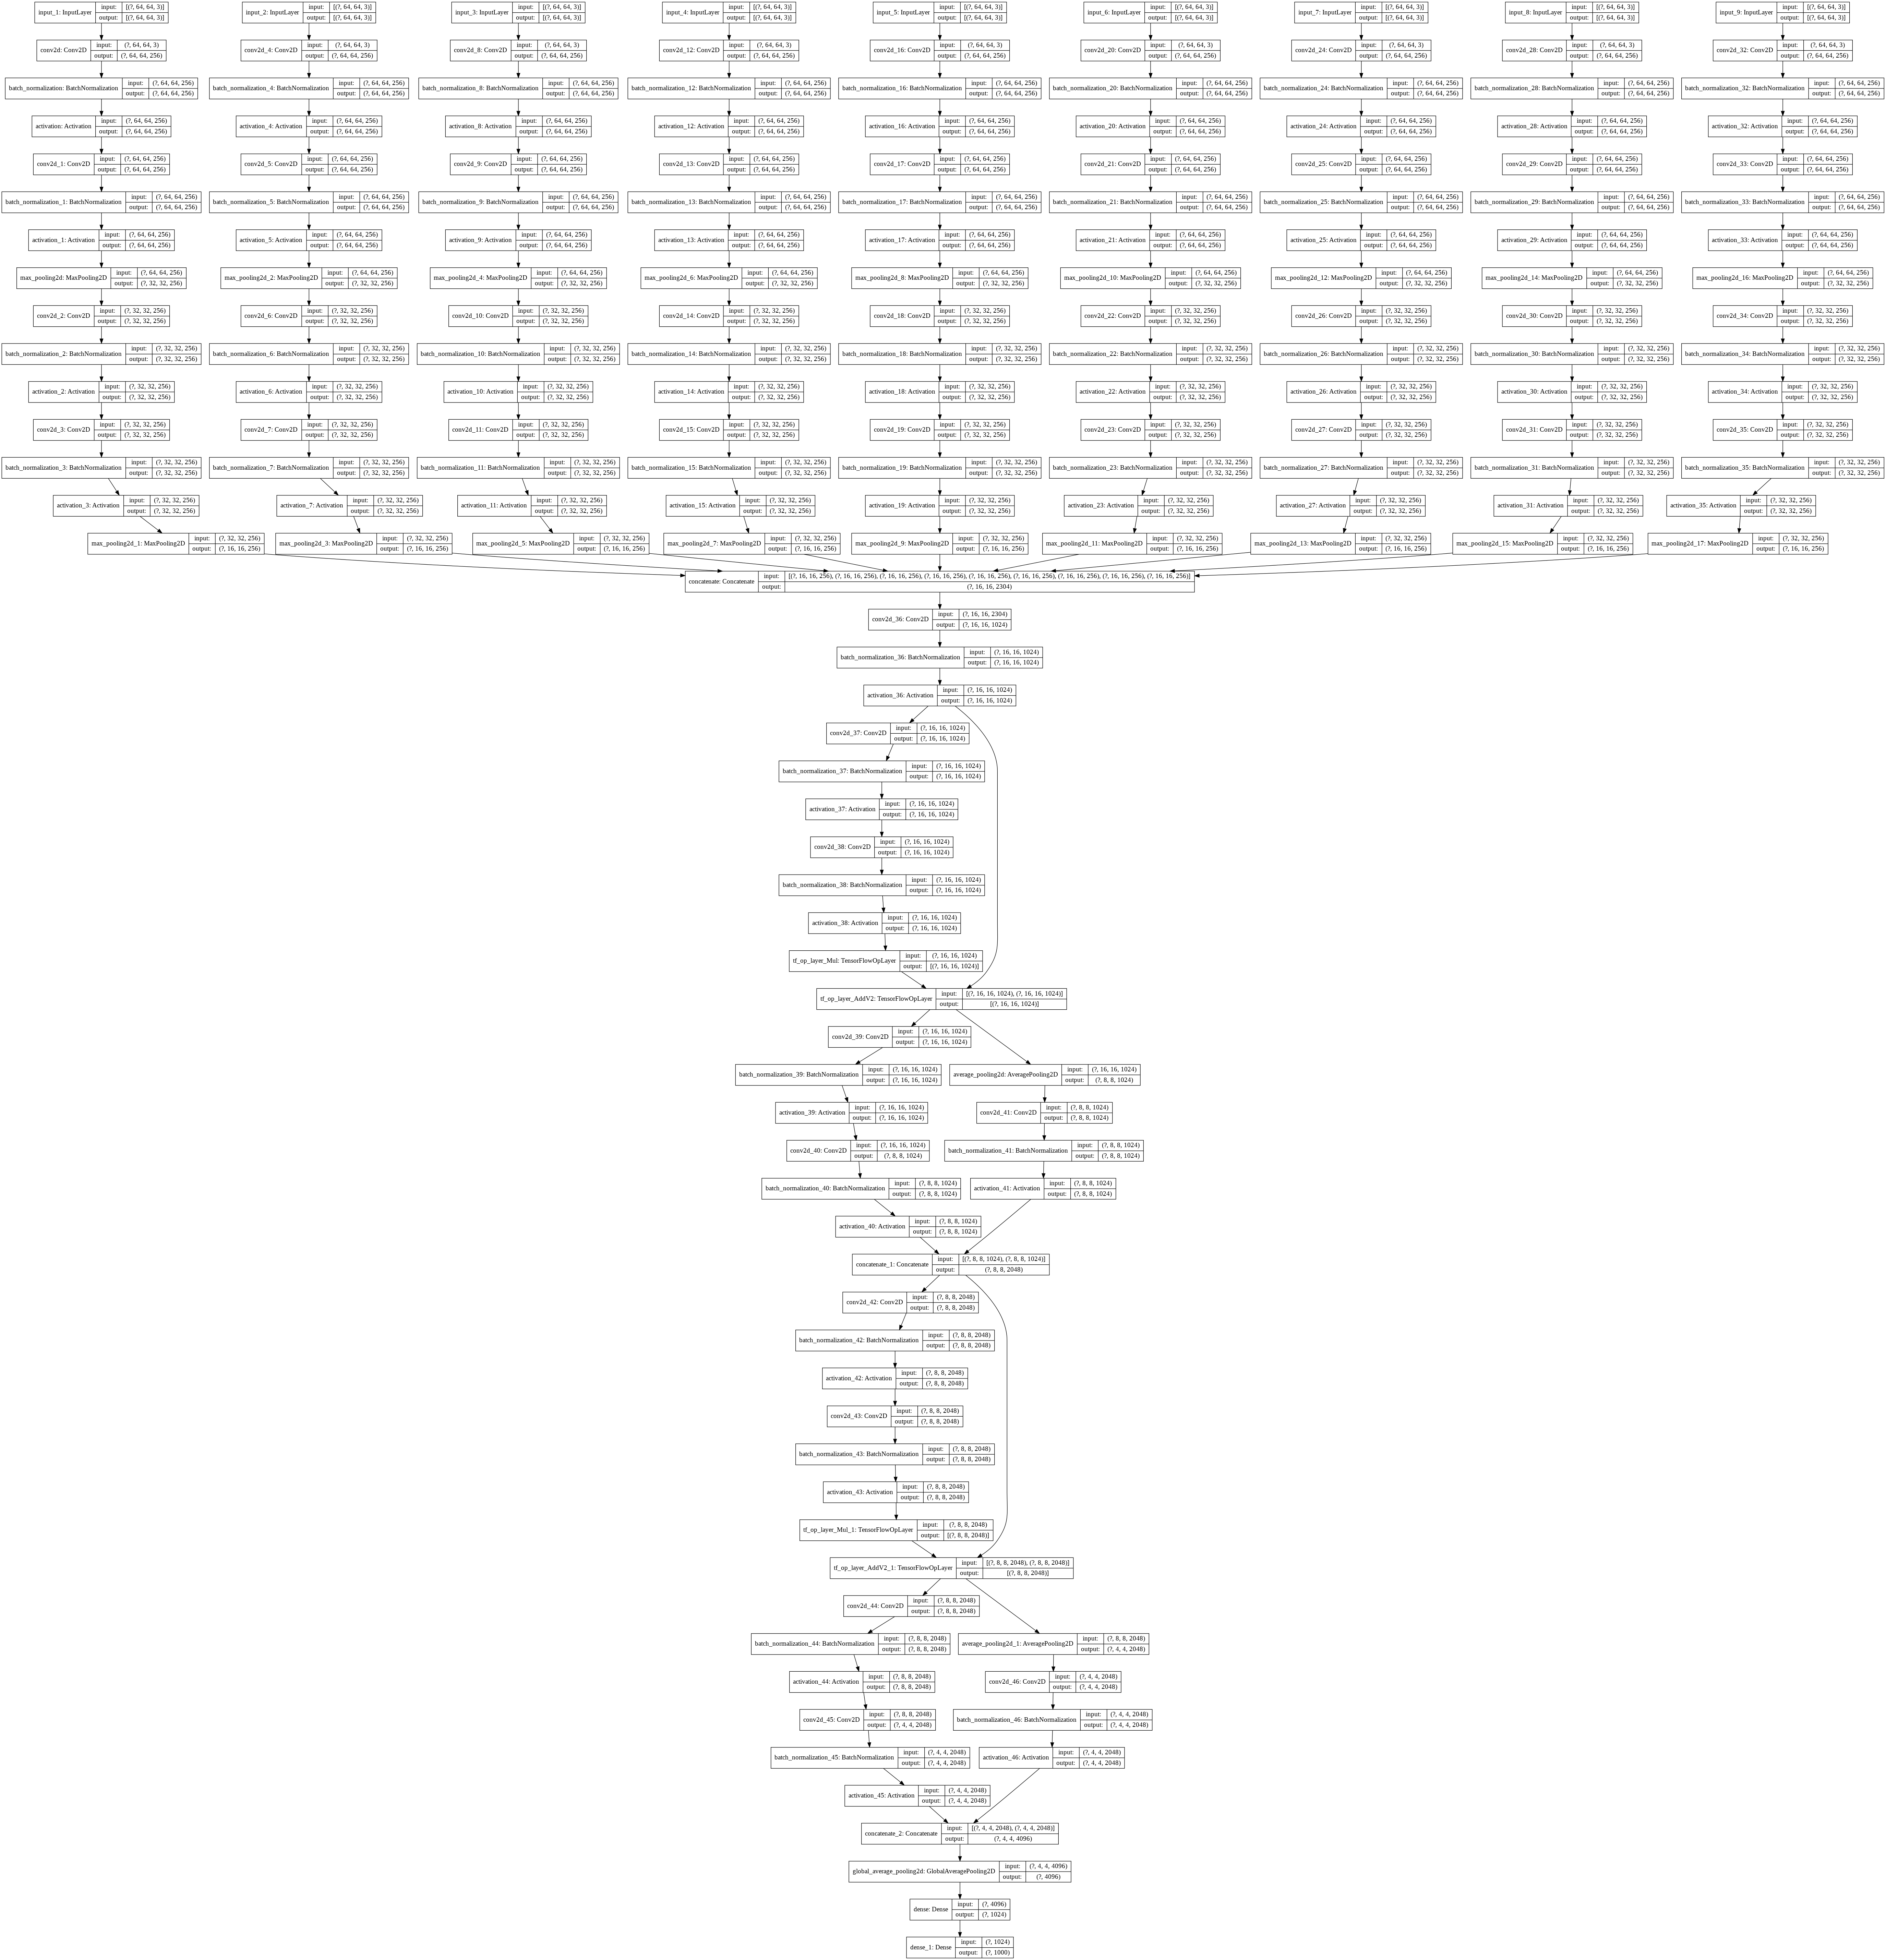

In [ ]:
plot_model(skid_model,show_shapes=True)

In [ ]:
!nvidia-smi

## Training Loop

In [ ]:
skid_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                         metrics=tf.keras.metrics.CategoricalAccuracy())

In [ ]:
history = skid_model.fit(tdg, epochs=50, shuffle=True, callbacks = get_callbacks()+[tf.keras.callbacks.LearningRateScheduler(LRscheduler)], validation_data=vdg)

Epoch 1/25
1130/1130 [==============================] - ETA: 0s - loss: 5.9324 - categorical_accuracy: 0.0414
Epoch 00001: val_categorical_accuracy improved from -inf to 0.10104, saving model to /content/saved_models/sagittal_217M_1000_4b2_AWGNvar001.h5
1130/1130 [==============================] - 1078s 954ms/step - loss: 5.9324 - categorical_accuracy: 0.0414 - val_loss: 4.6730 - val_categorical_accuracy: 0.1010
Epoch 2/25
1130/1130 [==============================] - ETA: 0s - loss: 4.1904 - categorical_accuracy: 0.1073
Epoch 00002: val_categorical_accuracy improved from 0.10104 to 0.14687, saving model to /content/saved_models/sagittal_217M_1000_4b2_AWGNvar001.h5
1130/1130 [==============================] - 1085s 960ms/step - loss: 4.1904 - categorical_accuracy: 0.1073 - val_loss: 3.8910 - val_categorical_accuracy: 0.1469
Epoch 3/25
1130/1130 [==============================] - ETA: 0s - loss: 3.5296 - categorical_accuracy: 0.1803
Epoch 00003: val_categorical_accuracy improved from 0.1

In [ ]:
#ax_history = sag_rocket_model.fit(tdg,epochs=10,shuffle=True, callbacks = get_callbacks()+[tf.keras.callbacks.LearningRateScheduler(LRscheduler)], validation_data=vdg)

In [ ]:
# tf.keras.models.save_model(skid_model,'./saved_models/path/to/best/model.h5',save_format='h5')

In [ ]:
h = {}
h['sparse_categorical_accuracy'] = history.history['categorical_accuracy']#+history2.history['sparse_categorical_accuracy']#+history3.history['sparse_categorical_accuracy']+history4.history['sparse_categorical_accuracy']
h['val_sparse_categorical_accuracy'] = history.history['val_categorical_accuracy']#+history2.history['val_sparse_categorical_accuracy']#+history3.history['val_sparse_categorical_accuracy']+history4.history['val_sparse_categorical_accuracy']
h['loss'] = history.history['loss']#+history2.history['loss']#+history3.history['loss']+history4.history['loss']
h['val_loss'] = history.history['val_loss']#+history2.history['val_loss']#+history3.history['val_loss']+history4.history['val_loss']

In [ ]:
history

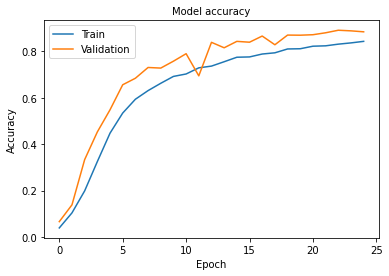

In [ ]:
plot_accuracy(h['sparse_categorical_accuracy'],h['val_sparse_categorical_accuracy'])

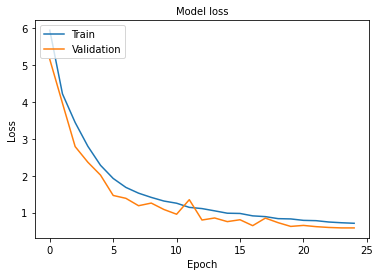

In [ ]:
plot_loss(h['loss'],h['val_loss'])